In [63]:
# !pip install kaggle
# # before using kaggle commands put kaggle.json token file in user directory
# import zipfile
# !kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis/code?select=twitter_validation.csv

# z= zipfile.ZipFile('twitter-entity-sentiment-analysis.zip')
# z.extractall()

In [64]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import re
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

You should consider upgrading via the 'c:\users\ayals\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayals\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
# data preview
df = pd.read_csv('twitter_training.csv', names=['id', 'entity', 'label', 'text'])
df.drop(['id', 'entity'], axis = 1, inplace = True)
df.dropna(inplace=True)
df.info()

test_df = pd.read_csv('twitter_validation.csv',names=['id', 'entity', 'label', 'text'])
test_df.drop(['id', 'entity'], axis = 1, inplace = True)
test_df.dropna(inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   73996 non-null  object
 1   text    73996 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1000 non-null   object
 1   text    1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB


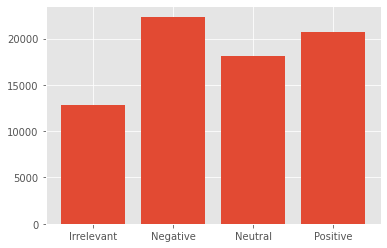

In [66]:
counts_df = df.groupby(['label']).size().reset_index(name='counts')

style.use('ggplot')
plt.bar(counts_df['label'], counts_df['counts'])
plt.show()

In [67]:
# change labels to numbers
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))
lancaster=LancasterStemmer()
en_stops = en_stops | {'im', 'ur', 'r', 'ma'}
def filter_tokens(tokens):
    """
    filter tokens by stemming and remove stopwords
    :input:
    tokens: list of strings
    
    return: 
    filterd tokens: list of strings
    """
    filtered_tokens = []
    for token in tokens:
        token = lancaster.stem(token)
        if token not in en_stops:
            filtered_tokens.append(token)
    return filtered_tokens

def preprocess_df(dirty_df):
    labels_dict = {'Positive':1, 'Neutral':0, 'Negative':2, 'Irrelevant':3}
    dirty_df['label'] = dirty_df['label'].apply(func=lambda e: labels_dict[e])
    
    dirty_df['tokenized'] = dirty_df['text'].apply(lambda e: re.findall('\w+',e.lower()))
    
    lens = dirty_df['tokenized'].apply(lambda e: len(e))

    dirty_df = dirty_df[lens != 0]
    
    # stem words and remove stopwords
    dirty_df['tokenized'] = dirty_df['tokenized'].apply(filter_tokens)
    
    return dirty_df, lens
    

In [68]:
df, lens = preprocess_df(df)
test_df, s = preprocess_df(test_df)
df.shape[0]/lens.mean()

<ipython-input-67-7a06a710b313>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirty_df['tokenized'] = dirty_df['tokenized'].apply(filter_tokens)


3778.596358089982

In [61]:
# for i,r in df.iterrows():
#     print(i,r['tokenized'])
# 'not' in en_stops

label                                                        0
text         @nvidia<unk><unk>? But why? You buy 5 cards co...
tokenized    [nvid, unk, unk, buy, 5, card, convint, thi, s...
Name: 74201, dtype: object

## save pre-processed data 

In [69]:

df.to_csv('preprocessed.csv', index = False)

### we see that we should use sequence models
### but will try both

# N gram models

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD

pipe = Pipeline([('count', CountVectorizer(max_features=80000,ngram_range=(1,2),stop_words=en_stops,lowercase=True)),
                 ('tfid', TfidfTransformer()),
                 ('pca', TruncatedSVD(n_components=20000))]).fit(df['text'])

x = pipe.transform(df['text'])
y = df['label'].values

X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.2, random_state=42)


### try naive base model

In [73]:
nb = MultinomialNB().fit(X_train,Y_train)
nb.score(X_test,Y_test)

0.8497117667005765